In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import scipy

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [4]:
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [5]:
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

In [6]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [7]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

In [8]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [9]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [10]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

In [11]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [12]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [13]:
df2['artistID'].min()

1

In [14]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [15]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [16]:
vals[-1]

2098

In [17]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [18]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [19]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [20]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [21]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [22]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [23]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [24]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [25]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [26]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [27]:
df2['weight'].max()

352698

In [28]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


In [29]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [30]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [31]:
df3['friendID'].max()

2098

In [32]:
df3['friendID'].nunique()

1892

In [33]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [34]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [35]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [36]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [37]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [38]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [39]:
df3['friendID'].max()

1891

In [40]:
df3.isnull().values.any()

False

In [41]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [ ]:
df5 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.csv")
df5.head()

Our last two dataframes seem exactly the same. Let's check this before we delete anything.

In [ ]:
def checkequality(A, B):

    df11 = A.sort_index(axis=1)
    df11 = df11.sort_values(df11.columns.tolist()).reset_index(drop=True)

    df22 = B.sort_index(axis=1)
    df22 = df22.sort_values(df22.columns.tolist()).reset_index(drop=True)
    return (df11 == df22).values.all()

a = checkequality(df4, df5)
print (a)

Two of our files are exactly the same. We can delete one of these accordingly.

In [ ]:
del df5

In [42]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4["artistID"] = df4["artistID"].apply(lambda x: str(x-1))

df4['artistID'] = df4['artistID'].astype(int)
df4['userID'] = df4['userID'].astype(int)

In [43]:
xyz =  np.array(df4['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [44]:
unique_list = list(set(vals))
unique_list.sort()
print(unique_list[-1])

usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

18743


17631

In [45]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [46]:
s = df4['artistID']

df4['artistID'] = s.map(diction)

In [47]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

In [48]:
df4

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,11288,4,1,7,2010
186475,1891,11288,292,1,5,2010
186476,1891,11288,2087,1,7,2010
186477,1891,11288,2801,1,5,2010


In [52]:
df.info

<bound method DataFrame.info of                     name                                           url  \
0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
4            Bella Morte          http://www.last.fm/music/Bella+Morte   
...                  ...                                           ...   
17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
17628             Aya RL               http://www.last.fm/music/Aya+RL   
17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   

                                              pictureURL  artID  
0        http

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [53]:
df['name'].value_counts()

MALICE MIZER                        1
BEAT!BEAT!BEAT!                     1
ãƒˆã‚¯ãƒžãƒ«ã‚·ãƒ¥ãƒ¼ã‚´            1
Thao with The Get Down Stay Down    1
ãƒªã‚¢ãƒ»ãƒ‡ã‚£ã‚¾ãƒ³               1
                                   ..
Innerpartysystem                    1
Helia                               1
Devil Sold His Soul                 1
Nevea Tears                         1
Grzegorz Tomczak                    1
Name: name, Length: 17632, dtype: int64

In [54]:
df1['tagID'].value_counts()

1        1
8368     1
8359     1
8360     1
8361     1
        ..
4059     1
4060     1
4061     1
4062     1
12648    1
Name: tagID, Length: 11946, dtype: int64

After initial observation, I feel the timestamp dataframe is of little use to me and hence disregard it. As per the readme file we have 1892 users and 17632 artists in our data.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

In [60]:
played

,name,url,pictureURL,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1,240,1,152
...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...,17630,423,17630,286


We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [61]:
played.drop(columns=['pictureURL'], inplace=True)

In [62]:
played

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286


In [63]:
mean = played['played'].mean()
print("The mean number of times a user listens to a song is: " + str(mean))

The mean number of times a user listens to a song is: 745.2439300256372


In [64]:
median = played['played'].median()
print("The median number of times a user listens to a song is: " + str(median))

The median number of times a user listens to a song is: 260.0


<AxesSubplot:>

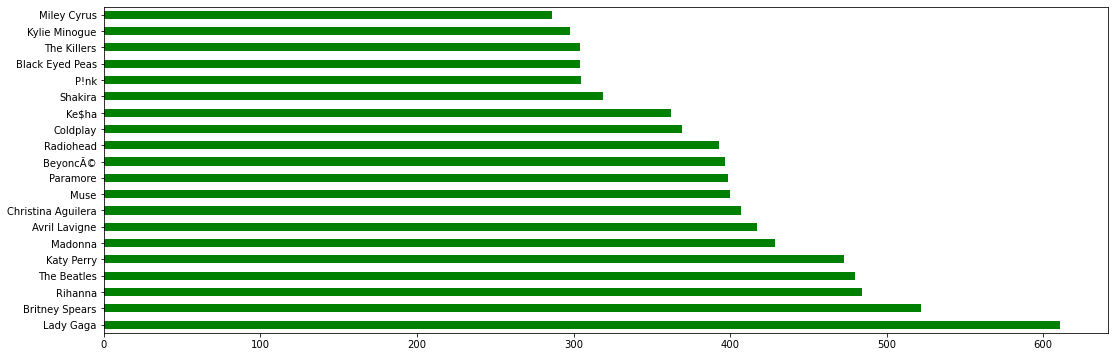

In [65]:
played['name'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

<AxesSubplot:xlabel='played'>

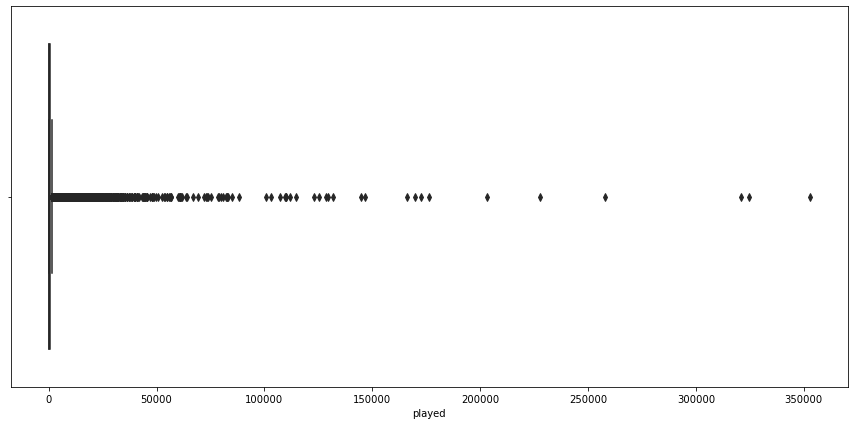

In [66]:
plt.figure(figsize=[15,7])
sns.boxplot(x=played['played'], color=".25")

There appears to be quite a lot of outliers here in the played column. Some users have obviously listened to their songs far more times than the average. We double check our values for mean and median earlier and can confirm there are quite a few outliers here.

In [67]:
played.describe()

,artID,userID,artistID,played
count,92834.000,92834.000,92834.000,92834.000
mean,3235.737,944.222,3235.737,745.244
std,4197.217,546.751,4197.217,3751.322
min,0.000,0.000,0.000,1.000
25%,430.000,470.000,430.000,107.000
50%,1237.000,944.000,1237.000,260.000
75%,4266.000,1416.000,4266.000,614.000
max,17631.000,1891.000,17631.000,352698.000


In [68]:
played.describe(include=[np.object])

C:\Users\user\AppData\Local\Temp/ipykernel_21248/3055805386.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  played.describe(include=[np.object])


,name,url
count,92834,92834
unique,17632,17632
top,Lady Gaga,http://www.last.fm/music/Lady+Gaga
freq,611,611


In [69]:
grouped_multiple = played.groupby(['artistID', 'name']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [70]:
artdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [71]:
artdf

,artistID,name,mean,med,max,sum
283,283,Britney Spears,4584.559,1000.500,131733,2393140
66,66,Depeche Mode,4614.567,567.000,352698,1301308
83,83,Lady Gaga,2113.563,590.000,114672,1291387
286,286,Christina Aguilera,2600.504,739.000,176133,1058405
492,492,Paramore,2414.659,417.000,227829,963449
...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1
13713,13713,ZÃœNDER,1.000,1.000,1,1
13712,13712,Evil Masquerade,1.000,1.000,1,1
16239,16239,Gosling,1.000,1.000,1,1


In [72]:
pt2 = artdf.head(20)

<AxesSubplot:title={'center':'Biggest artists by no of listens'}, xlabel='Artist', ylabel='Listens (millions)'>

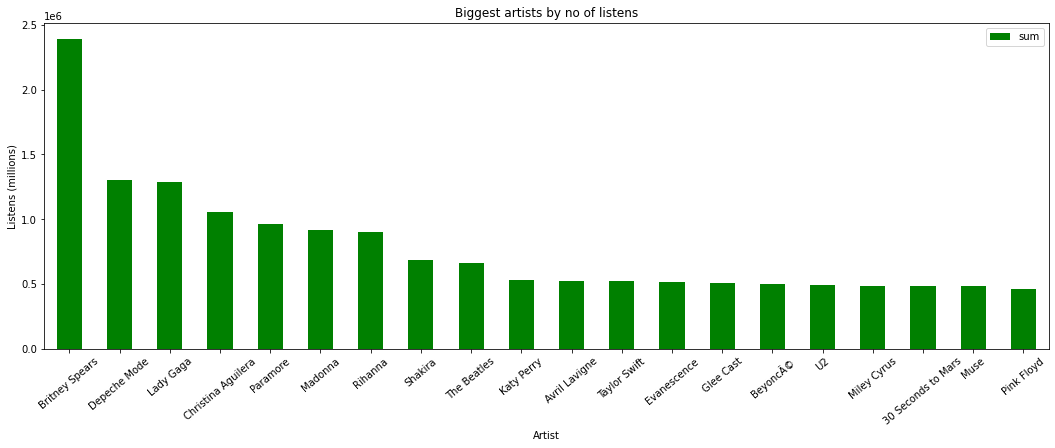

In [73]:
pt2.plot.bar(x = 'name', y = 'sum', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='Listens (millions)', title='Biggest artists by no of listens')

In [74]:
grouped_multiple = played.groupby(['userID']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [75]:
userdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [76]:
pt3 = userdf.head(20)

<AxesSubplot:title={'center':'Users with by no of listens'}, xlabel='User', ylabel='Listens'>

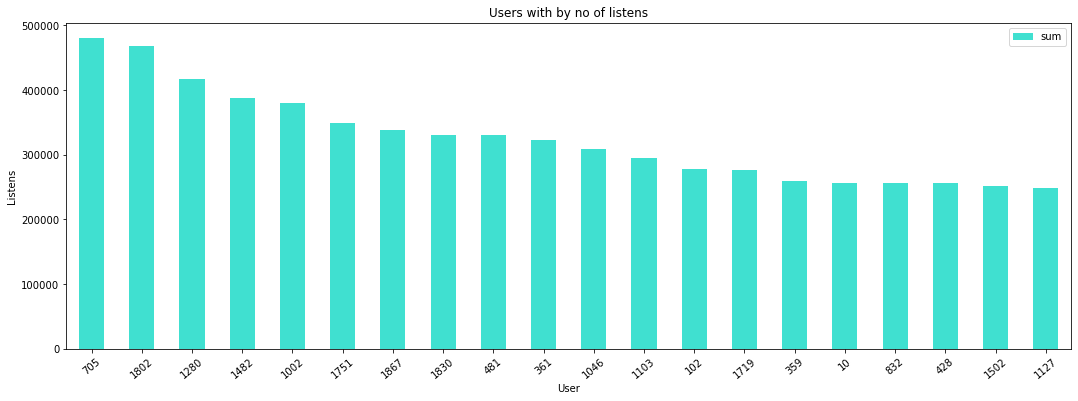

In [77]:
pt3.plot.bar(x = 'userID', y = 'sum', rot = 40, figsize=(18, 6), color='turquoise', xlabel='User', ylabel='Listens', title='Users by highest number of listens')

In [78]:
artdf['mean']

283     4584.559
66      4614.567
83      2113.563
286     2600.504
492     2414.659
          ...   
16522      1.000
13713      1.000
13712      1.000
16239      1.000
16241      1.000
Name: mean, Length: 17632, dtype: float64

In [79]:
played.shape

(92834, 6)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

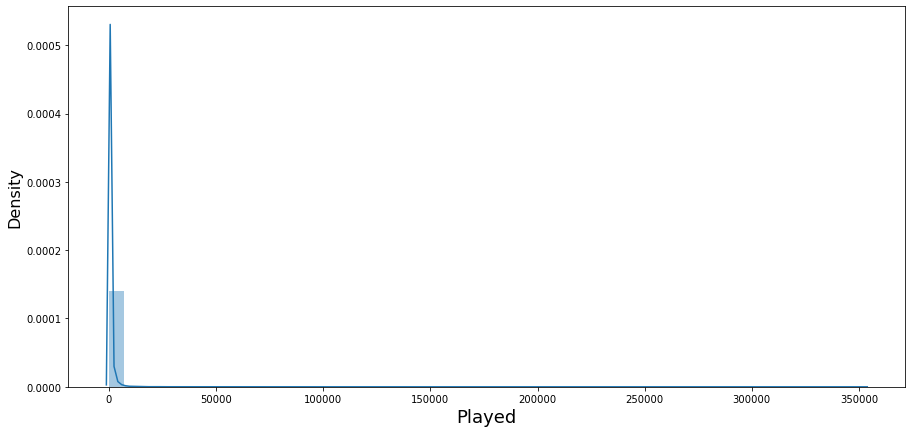

In [80]:
plt.figure(figsize=[15,7])
sns.distplot(played['played'])
plt.xlabel('Played', fontsize=18)
plt.ylabel('Density', fontsize=16)

The majority of values seem around the 1k or less mark. There are a lot of outlier values however going as far as 350,000 for the most extreme values. This confirms our earlier boxplot looking at these values in a clear manner.

In [81]:
xyz = pd.DataFrame(played['name'].value_counts())

In [82]:
xyz = xyz.reset_index()

In [83]:
xyz.rename(columns={'index': 'name', 'name': 'unique'}, inplace=True)

In [84]:
xyz

,name,unique
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
...,...,...
17627,Karmina,1
17628,Alexandre Desplat & Aaron Zigman,1
17629,Burning Brides,1
17630,ozzy,1


In [85]:
merged_df = artdf.merge(xyz, how = 'inner', on = ['name', 'name'])

In [86]:
merged_df

,artistID,name,mean,med,max,sum,unique
0,283,Britney Spears,4584.559,1000.500,131733,2393140,522
1,66,Depeche Mode,4614.567,567.000,352698,1301308,282
2,83,Lady Gaga,2113.563,590.000,114672,1291387,611
3,286,Christina Aguilera,2600.504,739.000,176133,1058405,407
4,492,Paramore,2414.659,417.000,227829,963449,399
...,...,...,...,...,...,...,...
17627,16522,K-Precise,1.000,1.000,1,1,1
17628,13713,ZÃœNDER,1.000,1.000,1,1,1
17629,13712,Evil Masquerade,1.000,1.000,1,1,1
17630,16239,Gosling,1.000,1.000,1,1,1


In [87]:
percent = []
val = merged_df['unique']
total = played['userID'].nunique()
percent = []
for i in range(len(val)):
    y = val[i] / total
    percent.append(y)
    #print(y)

In [88]:
percent = np.array(percent)
artdf['Percentage'] = percent.tolist()

In [89]:
artdf

,artistID,name,mean,med,max,sum,Percentage
283,283,Britney Spears,4584.559,1000.500,131733,2393140,0.276
66,66,Depeche Mode,4614.567,567.000,352698,1301308,0.149
83,83,Lady Gaga,2113.563,590.000,114672,1291387,0.323
286,286,Christina Aguilera,2600.504,739.000,176133,1058405,0.215
492,492,Paramore,2414.659,417.000,227829,963449,0.211
...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1,0.001
13713,13713,ZÃœNDER,1.000,1.000,1,1,0.001
13712,13712,Evil Masquerade,1.000,1.000,1,1,0.001
16239,16239,Gosling,1.000,1.000,1,1,0.001


In [90]:
artdf['unique'] = merged_df['unique'].values

In [91]:
artdf

,artistID,name,mean,med,max,sum,Percentage,unique
283,283,Britney Spears,4584.559,1000.500,131733,2393140,0.276,522
66,66,Depeche Mode,4614.567,567.000,352698,1301308,0.149,282
83,83,Lady Gaga,2113.563,590.000,114672,1291387,0.323,611
286,286,Christina Aguilera,2600.504,739.000,176133,1058405,0.215,407
492,492,Paramore,2414.659,417.000,227829,963449,0.211,399
...,...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1,0.001,1
13713,13713,ZÃœNDER,1.000,1.000,1,1,0.001,1
13712,13712,Evil Masquerade,1.000,1.000,1,1,0.001,1
16239,16239,Gosling,1.000,1.000,1,1,0.001,1


In [92]:
artdf['Percentage'] = artdf['Percentage'].multiply(100)

In [93]:
artdf = artdf.sort_values(by=['Percentage'], ascending=False)

<AxesSubplot:title={'center':'Percentage of users who listen to most popular artists'}, xlabel='Artist', ylabel='% of unique users who listen'>

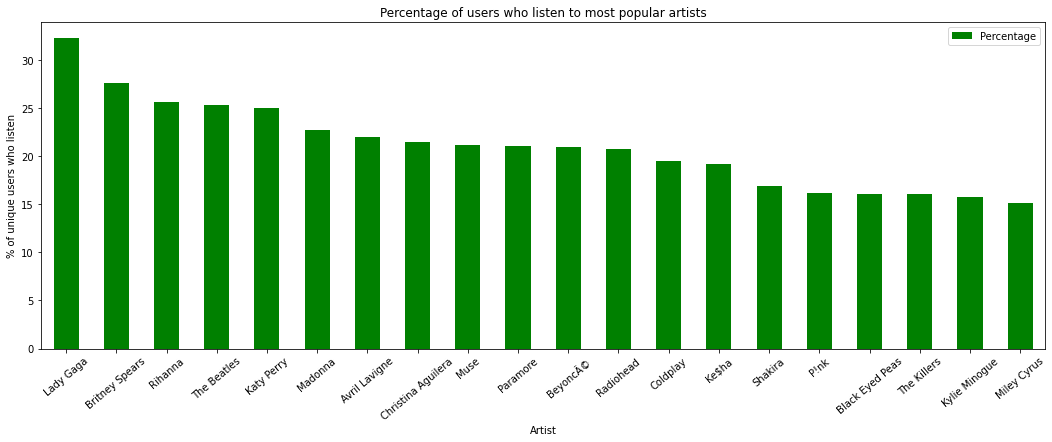

In [94]:
pt2 = artdf.head(20)
pt2.plot.bar(x = 'name', y = 'Percentage', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='% of unique users who listen', title='Percentage of users who listen to most popular artists')

In [95]:
values = [1, 2, 3, 4, 5]
for i in range(len(values)):
    x = len(artdf[artdf['Percentage'] <= values[i]])
    print("The percentage of artists with " + str(values[i]) + "% or less users listening to them is " + str(x) + ".")

The percentage of artists with 1% or less users listening to them is 16794.
The percentage of artists with 2% or less users listening to them is 17200.
The percentage of artists with 3% or less users listening to them is 17350.
The percentage of artists with 4% or less users listening to them is 17430.
The percentage of artists with 5% or less users listening to them is 17497.


We can tell on the whole of the 17632 artists that there are actually very few who are listened to by a wide audience. There are less than 1000 artists who have more than 1% of users listening to them. This means our data is probably leaned very heavily towards the most popular artists such as Britney Spears or Lady Gaga as per our barchart above.

In [96]:
z = played[['name', 'artistID']]

In [97]:
z = z.drop_duplicates()

In [98]:
z

,name,artistID
0,MALICE MIZER,0
3,Diary of Dreams,1
15,Carpathian Forest,2
18,Moi dix Mois,3
20,Bella Morte,4
...,...,...
92829,Diamanda GalÃ¡s,17627
92830,Aya RL,17628
92831,Coptic Rain,17629
92832,Oz Alchemist,17630


In [99]:
played

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286


In [100]:
played.head()

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152


I was going to try to incorporate the tags as part of my recommender system but as per above I seem to lose data just by the shape and even looking at artistID 1 we see this ID occurs three times in our played data and only twice in our tagged dataset. This is porbably due to the fact the users left no tags on this. We also have some improper values for tags as per above such as "better than lady gaga" and "#NAME?" which aren't going to add any information to our data. If we choose a subset of tags and take out values such as these that aren't as common or add any information we could work with this then. However, this would mean trimming our dataset down further. With less data to work with this might negatively impact the effectiveness of our recommender system.

In [101]:
df4[df4['artistID'] == 1]

,userID,artistID,tagID,day,month,year
3251,37,1,30,1,1,2009
3252,37,1,127,1,8,2009
3253,37,1,575,1,7,2008
21145,211,1,61,1,10,2009
26470,247,1,30,1,3,2008
...,...,...,...,...,...,...
147516,1515,1,179,1,1,2010
147517,1515,1,190,1,1,2010
147518,1515,1,575,1,1,2010
170778,1740,1,179,1,12,2006


This confirms that user 34 does not leave a tag on this artist's work. This is why we lose the rows we do when we try to incorporate the tags data into the listened data. We will disregard this for now.

# Sparse Representation of Played matrix

In [102]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
    matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
    num_plays = len(M.nonzero()[1]) # Number of times any artist has been interacted with
    sparsity = 100 * (1 - float(num_plays / matrix_size))
    return sparsity

## Normalising our played column
Next, one of the crucial aspects of our recommender system would be dealing with our played column. With such a diverse number of values from the range of 0 to over 350,000 we would have to deal with these appropriately. Our system would not be able to handle values of such a high nature and when I tried to run this I would get very high train errors and "nan" values for test error. I looked at a variety of different ways to normalize this value as a result and I would only incorporate two of these into my dataframe. I looked at capping any values above the 2,000 mark in our played column at 2,000 but decided against this method. As a result the methods I looked at were:

##### 1) Simple Normalization - normalizing all values based off the highest value in the "played" column.

##### 2) User based Normalization - grouping our played column by users and normalizing each user based off their own max value. I implemented this as a column called "playedUserNorm". This had the best results and was the column I implemented below.

##### 3) Play Count Scaled - here I would take each value in the column and take it away from the minimum value in the column. I would then divide this by the max value of the column minus the minimum value. I implemented this with the column "playCountScaled".

##### 4) Robust Scaling method - here we would scale each feature of the data set by subtracting the median and then dividing by the interquartile range. I tried this method but the results were poor and implementing it take a long time to run.


In [105]:
sm = played['played'].groupby(played['userID']).max()
artss = np.array(played['userID'])
playzz = np.array(played['played'])
#artss[-1]
newnorm = []
for i in range(len(playzz)):
    index = artss[i]
    val = playzz[i] / sm[index]
    newnorm.append(val)

In [106]:
newnorm = np.array(newnorm)

#add newnorm array as new column in DataFrame
played['playedUserNorm'] = newnorm.tolist()

In [107]:
played['playedUserNorm'].max()

1.0

In [108]:
pc = played.played
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

played = played.assign(playCountScaled=play_count_scaled)

In [109]:
# played["playBasicNorm"] = played["played"] / played["played"].max()

In [110]:
# played['playCountScaled'].equals(played['playBasicNorm'])

In [111]:
played.head()

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.056,0.001
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065,0.001
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025,0.000
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.151,0.003
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154,0.000


In [112]:
#newcol = []
#pl = np.array(played['played'])
#for i in range(len(pl)):
#    val = (pl[i] - played['played'].median())  / (played['played'].quantile(0.75) - played['played'].quantile(0.25))
#    newcol.append(val)

In [113]:
#newcol = np.array(newcol)

#add newnorm array as new column in DataFrame
#played['playedRobust'] = newcol.tolist()

In [114]:
played.dtypes

name                object
url                 object
artID                int64
userID               int64
artistID             int64
played               int64
playedUserNorm     float64
playCountScaled    float64
dtype: object

In [115]:
def build_rating_sparse_tensor(ratings_df):
  # ========================= Complete this section ============================
    indices = ratings_df[['userID', 'artID']].values
    values = ratings_df['playedUserNorm'].values
  # ============================================================================

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(played.userID.unique()), len(played.artID.unique())])

In [116]:
len(played.userID.unique())

1892

In [119]:
played.shape[0]

92834

In [120]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    predictions = tf.reduce_sum(
    tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) * tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Building Model

In [121]:
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations = 100, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# Build and Run the Model

In [122]:
from sklearn.model_selection import train_test_split
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
    #train_ratings, test_ratings = train_test_split(ratings, test_size=0.5)
    train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [123]:
def split_dataframe(df, holdout_fraction=0.3):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [124]:
xyz = played[['userID', 'artID', 'playedUserNorm']]

 iteration 1000: train_error=0.031697, test_error=0.691478

[{'train_error': 0.031697292, 'test_error': 0.69147766}]

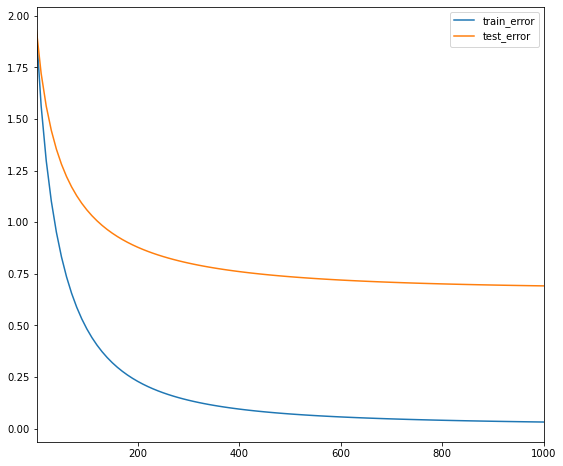

In [126]:
model = build_model(xyz,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

I tried to build my model but the high values for listens was giving me errors like so "InvalidArgumentError: indices[4073] = 2077 is not in [0, 1892)". 

This was why I changed the artist and user ID's to 1.) start from zero and 2.) increment by 1 until the length of unique values - 1. I had to normalise my weights then as I kept returning nan values for train and test errors above.

In [127]:
played.head(6)

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.056,0.001
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065,0.001
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025,0.000
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.151,0.003
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154,0.000
5,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,303,1,3466,1.000,0.010


In [128]:
#played[played["played"] > 2000]["played"] = 2000

In [129]:
#indexes = played[played["played"] > 2000].index

In [130]:
#played.iloc[indexes,5] = 2000

In [131]:
#played.head()

# Inspect Embeddings

In [132]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [133]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  df[df['name'].str.contains(title_substring)].index.values
  titles = df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artID"][artistID], model.embeddings["artID"],
      measure)
  score_key = measure + ' score'
  df7 = pd.DataFrame({
      score_key: list(scores),
      'names': df['name'],
  })
  display.display(df7.sort_values([score_key], ascending=False).head(k))

In [134]:
artist_neighbors(model, "Lady Gaga", DOT)
artist_neighbors(model, "Lady Gaga", COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
10117,0.965,Mad Sin
14466,0.934,Sha
14755,0.906,Randy Orton
8974,0.891,Haemorrhage
6063,0.887,The Beta Band
10065,0.883,Brian Bennett


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000,Lady Gaga
294,0.764,Katy Perry
282,0.709,Rihanna
296,0.686,P!nk
283,0.682,Britney Spears
460,0.669,Ke$ha


# Regularized Matrix

In [135]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(xyz)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.032623, test_error_observed=0.050443, observed_loss=0.032623, regularization_loss=0.016983, gravity_loss=0.000805

[{'train_error_observed': 0.03262261, 'test_error_observed': 0.050443094},
 {'observed_loss': 0.03262261,
  'regularization_loss': 0.01698325,
  'gravity_loss': 0.0008048651}]

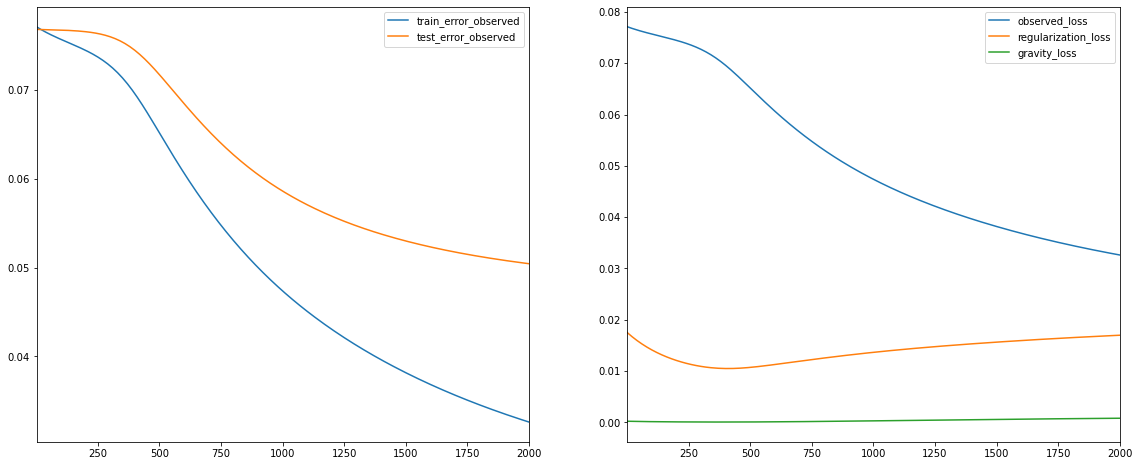

In [136]:
reg_model, u, v  = build_regularized_model(xyz, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [137]:
artist_neighbors(reg_model, "Lady Gaga", DOT)
artist_neighbors(reg_model, "Lady Gaga", COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
83,11.176,Lady Gaga
282,3.268,Rihanna
283,2.478,Britney Spears
673,2.448,Glee Cast
460,2.442,Ke$ha
289,2.385,BeyoncÃ©


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000,Lady Gaga
1754,0.722,Maria Rita
537,0.664,Nicole Scherzinger
460,0.655,Ke$ha
4704,0.649,Natalia Kills
317,0.644,The Saturdays


These are actually very good recommendations produced by our recommender system based off each users unique normalised values based on the highest listened value they obtained. 

# Alternate method

In [139]:
played.shape

(92834, 8)

In [140]:
played.dtypes

name                object
url                 object
artID                int64
userID               int64
artistID             int64
played               int64
playedUserNorm     float64
playCountScaled    float64
dtype: object

In [142]:
sub = played[['userID', 'artID', 'playedUserNorm']]

In [143]:
sub.head()

,userID,artID,playedUserNorm
0,31,0,0.056
1,256,0,0.065
2,729,0,0.025
3,130,1,0.151
4,240,1,0.154
...,...,...,...
92829,423,17627,0.041
92830,423,17628,0.040
92831,423,17629,0.039
92832,423,17630,0.039


In [145]:
train, test = train_test_split(sub, test_size=0.7)

In [146]:
train.head()

,userID,artID,playedUserNorm
6346,821,169,0.044
2097,533,61,0.143
19668,35,338,0.041
38790,321,908,1.000
32385,845,680,0.188


In [147]:
test.head()

,userID,artID,playedUserNorm
30972,347,609,0.216
37619,777,859,0.251
65185,868,3360,0.333
6860,1759,181,0.107
27718,10,514,0.016


In [148]:
n_users = len(sub.userID.unique())
n_users

1892

In [149]:
n_artist = len(sub.artID.unique())
n_artist

17632

In [150]:
# creating artist embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, user_vec])
model = Model([user_input, artist_input], prod)
model.compile('adam', 'mean_squared_error')

In [151]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [152]:
model.evaluate([test.userID, test.artID], test.playedUserNorm)

11.666054178543401

In [153]:
predictions = model.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[4.173607] 0.2158792650918635
[4.6073523] 0.2512254901960784
[0.6478031] 0.3333333333333333
[2.1924207] 0.10672358591248667
[0.46936107] 0.01596448613786749
[1.3001852] 0.038845331432644334
[1.1848242] 0.016197208112812132
[5.8000813] 0.03250222617987533
[2.6986322] 0.1
[1.636121] 0.06587523277467412


[None, None, None, None, None, None, None, None, None, None]

# Neural Network

In [154]:
# creating book embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artists")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([artist_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, artist_input], out)
model2.compile('adam', 'mean_squared_error')

In [155]:
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [156]:
model2.evaluate([test.userID, test.artID], test.playedUserNorm)

1871792.4377923796

In [157]:
predictions = model2.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[247.21103] 0.2158792650918635
[231.81247] 0.2512254901960784
[422.76147] 0.3333333333333333
[356.86636] 0.10672358591248667
[4487.904] 0.01596448613786749
[254.98761] 0.038845331432644334
[309.5708] 0.016197208112812132
[276.30463] 0.03250222617987533
[2306.0793] 0.1
[277.76935] 0.06587523277467412


[None, None, None, None, None, None, None, None, None, None]

# Visualizing Embeddings

In [158]:
# Extract embeddings
artist_em = model.get_layer("Artist-Embedding")
artist_em_weights = artist_em.get_weights()[0]

In [159]:
artist_em_weights[:5]

array([[ 0.04103883, -0.2710777 ,  0.28193265,  0.01121594, -0.21962109],
       [ 0.42227656, -0.44878516,  0.46648487, -0.12221594, -0.40105212],
       [-0.18079431, -0.13342255,  0.1553544 , -0.3333101 , -0.00778394],
       [ 0.150518  , -0.19249448,  0.1592992 ,  0.12258738, -0.12723902],
       [ 0.2513393 , -0.21272472,  0.1814355 , -0.22018886, -0.13649407]],
      dtype=float32)

<AxesSubplot:>

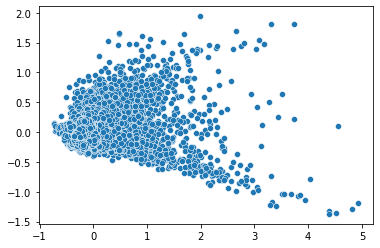

In [160]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [161]:
artist_em_weights = artist_em_weights / np.linalg.norm(artist_em_weights, axis = 1).reshape((-1, 1))
artist_em_weights[0][:10]
np.sum(np.square(artist_em_weights[0]))

1.0

<AxesSubplot:>

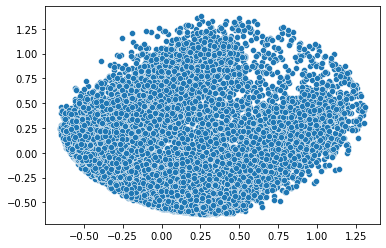

In [162]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [163]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(artist_em_weights)

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17633 samples in 0.037s...
[t-SNE] Computed neighbors for 17633 samples in 1.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17633
[t-SNE] Computed conditional probabilities for sample 2000 / 17633
[t-SNE] Computed conditional probabilities for sample 3000 / 17633
[t-SNE] Computed conditional probabilities for sample 4000 / 17633
[t-SNE] Computed conditional probabilities for sample 5000 / 17633
[t-SNE] Computed conditional probabilities for sample 6000 / 17633
[t-SNE] Computed conditional probabilities for sample 7000 / 17633
[t-SNE] Computed conditional probabilities for sample 8000 / 17633
[t-SNE] Computed conditional probabilities for sample 9000 / 17633
[t-SNE] Computed conditional probabilities for sample 10000 / 17633
[t-SNE] Computed conditional probabilities for sample 11000 / 17633
[t-SNE] Computed conditional probabilities for sample 12000 / 17633
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:>

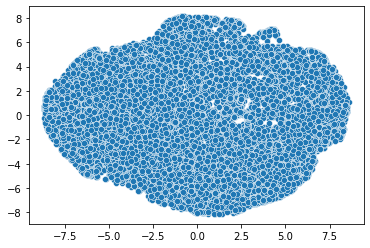

In [164]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Making Recommendations

In [165]:
# Creating dataset for making recommendations for the first user
artist_data = np.array(list(set(sub.artID)))
artist_data

array([    0,     1,     2, ..., 17629, 17630, 17631])

In [166]:
user = np.array([83 for i in range(len(artist_data))])
user

array([83, 83, 83, ..., 83, 83, 83])

In [167]:
predictions = model.predict([user, artist_data])

predictions = np.array([a[0] for a in predictions])

recommended_artist_ids = (predictions).argsort()[:5]

recommended_artist_ids

array([8131, 8135, 8324, 2754, 8139], dtype=int64)

In [168]:
predictions[recommended_artist_ids]

array([-1.1105492 , -1.0870131 , -1.0431927 , -0.9887378 , -0.98679465],
      dtype=float32)

In [169]:
df[df['artID'].isin(recommended_artist_ids)]

,name,url,pictureURL,artID
2754,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754
8131,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131
8135,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135
8139,Luctus,http://www.last.fm/music/Luctus,http://userserve-ak.last.fm/serve/252/8688989.jpg,8139
8324,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324


Let's check does our recommender produce novel results. In our recommender system as mentioned earlier it can be hard to gauge good recommenders in a formal manner (not a subjective manner such as a user rating the recommendations) as there is no ratings just listening figures. Users would eventually tire of being suggested the same artists so checking our recommender to see if it produces novel results is a good barometer of it's quality to start.

In [217]:
test = played[played['userID'] == 83]

In [219]:
test[test['artID'].isin(recommended_artist_ids)]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled


Our recommender has produced completely novel results here for the user. This is a good starting point for our recommender. Let's delve further into it's results.

In [224]:
tags[tags['userID'] == 83]

,tagID,tagValue,userID,artistID
9376,18,electronic,83,64
9377,18,electronic,83,418
15673,24,pop,83,64
15674,24,pop,83,256
15675,24,pop,83,262
...,...,...,...,...
142425,1080,mexico,83,3903
142473,1083,dirty south,83,291
142474,1083,dirty south,83,495
142475,1083,dirty south,83,1270


# Alternate Method 2

In [170]:
played

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.056,0.001
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065,0.001
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025,0.000
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.151,0.003
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154,0.000
...,...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301,0.041,0.001
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294,0.040,0.001
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287,0.039,0.001
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286,0.039,0.001


In [171]:
ratings_df = played.pivot(
    index='userID', 
    columns='artistID', 
    values='playedUserNorm'
)

In [172]:
ratings = ratings_df.fillna(0).values

In [173]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [174]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [175]:
train, val = train_test_split(ratings)

In [176]:
train.shape

(1892, 17632)

In [177]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [178]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [179]:
recommender = Recommender().fit(train, val)

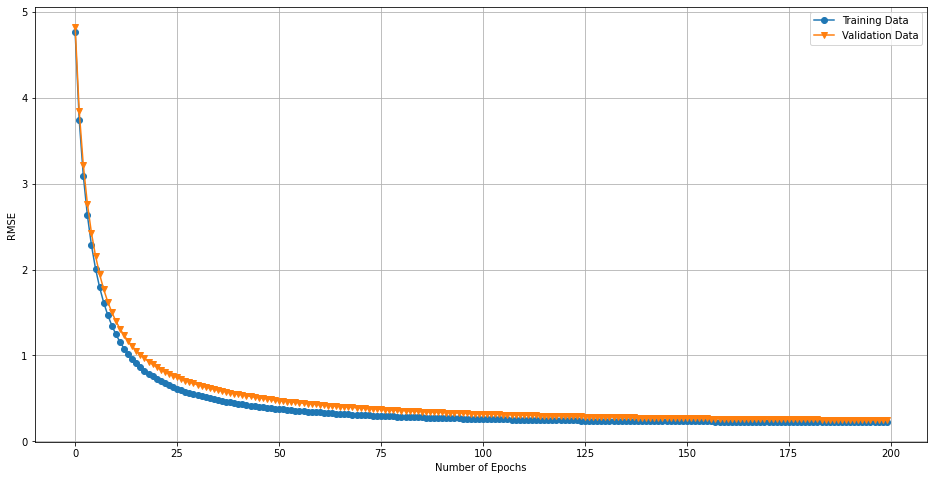

In [182]:
plt.figure(figsize=(16,8))
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Making Recommendations

In [183]:
user_id = 15
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [184]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
    artist_recommendations = artists_df[artists_df.artID.isin(top_n_artists.artistId)].reset_index(drop=True)
    artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
    return artist_recommendations.sort_values("rating", ascending=False)

In [185]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(df, existing_ratings_index, existing_ratings)

,name,url,pictureURL,artID,rating
0,Lady Gaga,http://www.last.fm/music/Lady+Gaga,http://userserve-ak.last.fm/serve/252/47390093...,83,1.000
1,The Killers,http://www.last.fm/music/The+Killers,http://userserve-ak.last.fm/serve/252/250099.jpg,223,0.125
2,Taylor Swift,http://www.last.fm/music/Taylor+Swift,http://userserve-ak.last.fm/serve/252/45447333...,338,0.100
3,Adam Lambert,http://www.last.fm/music/Adam+Lambert,http://userserve-ak.last.fm/serve/252/56430315...,538,0.087
4,Ellie Goulding,http://www.last.fm/music/Ellie+Goulding,http://userserve-ak.last.fm/serve/252/62251875...,542,0.045
5,Glee Cast,http://www.last.fm/music/Glee+Cast,http://userserve-ak.last.fm/serve/252/44433851...,673,0.042
6,Lights,http://www.last.fm/music/Lights,http://userserve-ak.last.fm/serve/252/40210269...,676,0.033
7,John Mayer,http://www.last.fm/music/John+Mayer,http://userserve-ak.last.fm/serve/252/385672.jpg,677,0.032
8,American Idiot Cast,http://www.last.fm/music/American+Idiot+Cast,http://userserve-ak.last.fm/serve/252/53866529...,678,0.030
9,Selena Gomez & the Scene,http://www.last.fm/music/Selena%2BGomez%2B%252...,http://userserve-ak.last.fm/serve/252/51703695...,680,0.026


In [186]:
create_artist_ratings(df, predictions_index, rating_predictions)

,name,url,pictureURL,artID,rating
0,Bilal Serbest,http://www.last.fm/music/Bilal+Serbest,http://userserve-ak.last.fm/serve/252/41059153...,2631,0.647
1,Alpinestars,http://www.last.fm/music/Alpinestars,http://userserve-ak.last.fm/serve/252/67343.jpg,4220,0.641
2,GIRL NEXT DOOR,http://www.last.fm/music/GIRL+NEXT+DOOR,http://userserve-ak.last.fm/serve/252/58768751...,5437,0.633
3,The Persuasions,http://www.last.fm/music/The+Persuasions,http://userserve-ak.last.fm/serve/252/373584.jpg,7931,0.633
4,Seba,http://www.last.fm/music/Seba,http://userserve-ak.last.fm/serve/252/17613945...,12390,0.627
5,Top,http://www.last.fm/music/Top,http://userserve-ak.last.fm/serve/252/56576915...,13658,0.624
6,Ena PÃ¡ 2000,http://www.last.fm/music/Ena+P%C3%A1+2000,http://userserve-ak.last.fm/serve/252/372386.jpg,14395,0.624
7,DJ Koze,http://www.last.fm/music/DJ+Koze,http://userserve-ak.last.fm/serve/252/45703561...,14998,0.623
8,Lindsay Lohan/Lindsay Lohan/Lindsay Lohan/Lind...,http://www.last.fm/music/Lindsay%2BLohan%252FL...,http://userserve-ak.last.fm/serve/252/54095047...,17236,0.621
9,Teodulija,http://www.last.fm/music/Teodulija,http://userserve-ak.last.fm/serve/252/291596.jpg,17575,0.621


In [187]:
played[played['userID'] == 15]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
1068,Daft Punk,http://www.last.fm/music/Daft+Punk,50,15,50,242,0.017,0.001
1960,Madonna,http://www.last.fm/music/Madonna,61,15,61,303,0.021,0.001
3298,Lady Gaga,http://www.last.fm/music/Lady+Gaga,83,15,83,1255,0.087,0.004
10537,The Killers,http://www.last.fm/music/The+Killers,223,15,223,610,0.042,0.002
10842,Green Day,http://www.last.fm/music/Green+Day,224,15,224,120,0.008,0.000
...,...,...,...,...,...,...,...,...
32999,Boyce Avenue,http://www.last.fm/music/Boyce+Avenue,694,15,694,116,0.008,0.000
33003,Shakira,http://www.last.fm/music/Shakira,695,15,695,115,0.008,0.000
33322,Ester Dean,http://www.last.fm/music/Ester+Dean,696,15,696,109,0.008,0.000
33323,The xx,http://www.last.fm/music/The+xx,697,15,697,107,0.007,0.000


In [188]:
df4.head()

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009


In [189]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

In [192]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")

In [193]:
tags.isnull().values.any()

False

In [222]:
tags['artistID'].max()

12522

<AxesSubplot:>

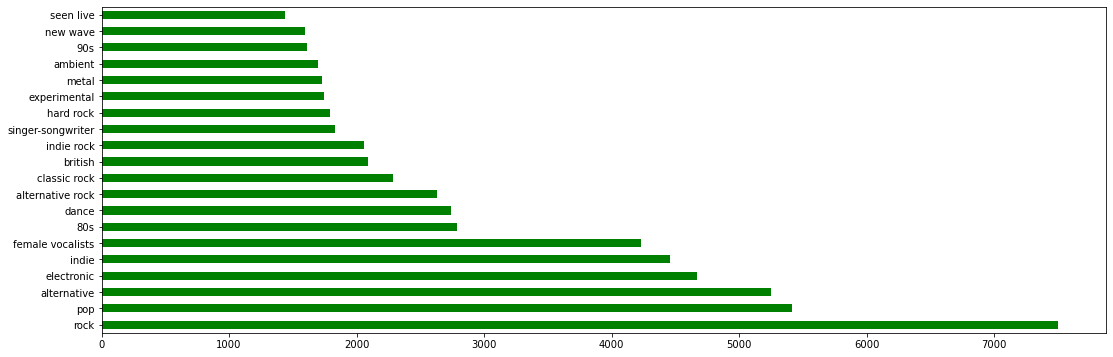

In [195]:
tags['tagValue'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

# Spotify Recommender system

In [196]:
import tekore as tk

In [197]:
client_id = 'cb3a434dfacd4fd6b0a65dc5f4f1bd2e'
client_secret = '39d56bef066c421f9e9ebc2bc0059ebc'

In [198]:
redirect_url = 'http://ca4015.com/callback/'

In [199]:
#conf = (client_id, client_secret, redirect_uri)
#token = tk.prompt_for_user_token(*conf, scope = tk.scope.every)

#spotify = tk.Spotify(token)

In [200]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
#client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
#sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [201]:
'''
username = 'kiansweeney11'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
'''

'\nusername = \'kiansweeney11\'\nclient_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) \nsp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)\nscope = \'user-top-read\'\ntoken = util.prompt_for_user_token(username, scope)\n\nif token:\n    sp = spotipy.Spotify(auth=token)\nelse:\n    print("Can\'t get token for", username)\n'

In [202]:
'''
artist_name = []
track_name = []
popularity = []
track_id = []
results = sp.current_user_top_tracks(limit=5,offset=0,time_range='medium_term')
for i, t in enumerate(track_results['tracks']['items']):
    artist_name.append(t['artists'][0]['name'])
    track_name.append(t['name'])
    track_id.append(t['id'])
    popularity.append(t['popularity'])
'''

"\nartist_name = []\ntrack_name = []\npopularity = []\ntrack_id = []\nresults = sp.current_user_top_tracks(limit=5,offset=0,time_range='medium_term')\nfor i, t in enumerate(track_results['tracks']['items']):\n    artist_name.append(t['artists'][0]['name'])\n    track_name.append(t['name'])\n    track_id.append(t['id'])\n    popularity.append(t['popularity'])\n"

In [203]:
'''
track_dataframe = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'popularity' : popularity})
print(track_dataframe.shape)
track_dataframe.head(10)
'''

"\ntrack_dataframe = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'popularity' : popularity})\nprint(track_dataframe.shape)\ntrack_dataframe.head(10)\n"

In [204]:
played

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.056,0.001
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065,0.001
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025,0.000
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.151,0.003
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154,0.000
...,...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301,0.041,0.001
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294,0.040,0.001
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287,0.039,0.001
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286,0.039,0.001


# Evaluation

We will now try to evaluate our results and methods attempted so far. I will look at using methods such as Recall, Precision, Coverage and F1 to validate our methods. I feel methods such as mean absolute error (MAE) and root mean square error (RMSE) are not suitable to our data provided. These look at the difference between the actual and predicted values, which are not really applicable to the data here. The predicted artist could be number 1 and the actual artist could be 2 and this would appear as a very good result using this method. However, the difference in genres and similarity of artist could be completely different and hence the result is misleading. We will look to implement evaluation using the "LightFM" python library.

In [205]:
import implicit
from tqdm import tqdm_notebook as tqdm
import matplotlib.ticker as ticker
from matplotlib import rc
from pandas.api.types import CategoricalDtype
import string
import re
import random
import math
from math import sqrt
from math import log
from collections import Counter, defaultdict
from operator import itemgetter
from pylab import rcParams
from pylab import savefig

In [210]:
# Create sparse matrix from dataframe object
def create_sparse_matrix(data):
  #get unique user ids and unique artist ids
  users = list(np.sort(data.userID.unique()))
  artists = list(data.artistID.unique())
  plays = list(data.playCountScaled)

  cat_type = CategoricalDtype(categories=users, ordered=True)
  rows = data.userID.astype(cat_type).cat.codes

  cat_type = CategoricalDtype(categories=artists, ordered=True)
  cols = data.artistID.astype(cat_type).cat.codes
  # we get the rows (user ids) and columns (artist ids) and populate them using plays
  plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))
  return plays_sparse

In [207]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
  matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
  num_plays = len(M.nonzero()[0]) # Number of times any artist has been interacted with
  sparsity = 100 * (1 - float(num_plays / matrix_size))
  return sparsity

In [208]:
def evaluate_lightfm(model, original, train, test, user_features=None, item_features=None, n_rec = 20):
    print("Evaluating LightFM...")
    print("Calculating Coverage...")
    catalog = []
    for user in tqdm(range(0, original.shape[0])):
      #get scores for this particular user for all artists
      rec_scores = model.predict(user,np.arange(original.shape[1]),user_features=user_features, item_features=item_features)
      #get top k items to recommend
      rec_items = (-rec_scores).argsort()[:20]
      #calculate coverage
      #coverage calculation
      for recs in rec_items:
        if recs not in catalog:
          catalog.append(recs)
            
    coverage = len(catalog)/float(original.shape[1])
    print("Calculating Recall at k...")
    recall = recall_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    print("Calculating Precision at k...")
    precision = precision_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    f1 = (2 * precision * recall) / (precision + recall)
    return coverage, precision, recall, f1

In [209]:
playedx = played[['userID','artistID', 'playedUserNorm']]
playedx.columns = ['userID','artistID', 'playedUserNorm']

#create sparse matrix
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72171848800758
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_21248/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 13.849206268787384 %
Recall: 8.068666584477983 %
Coverage: 0.8507259528130671 %
F1: 10.196667221368596 %


In [211]:
playedx = played[['userID','artistID', 'playCountScaled']]
playedx.columns = ['userID','artistID', 'playCountScaled']

#create sparse matrix
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72362497745786
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_21248/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 11.481481790542603 %
Recall: 6.7381535764321185 %
Coverage: 0.6749092558983666 %
F1: 8.492374960468903 %


Our chosen accuracy when normalising with each user's max score is better than our play count scaled metric.